Probability that N > 1200: 0.011


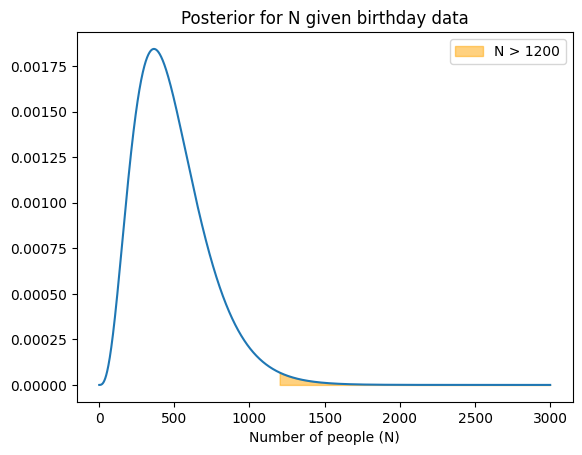

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Observed counts
k = np.array([2, 1, 0])
p = 1/365

# Range of possible N
N_grid = np.arange(1, 3001)

# Compute likelihood for each N
likelihood = (
    stats.binom.pmf(k[0], N_grid, p) *
    stats.binom.pmf(k[1], N_grid, p) * 
    stats.binom.pmf(k[2], N_grid, p)
)

# Uniform prior
prior = np.ones_like(N_grid)

# Posterior (unnormalized)
posterior = likelihood * prior
posterior /= posterior.sum()  # Normalize

# Probability N > 1200
prob_gt_1200 = posterior[N_grid > 1200].sum()
print(f"Probability that N > 1200: {prob_gt_1200:.3f}")

# Optional: plot posterior
plt.plot(N_grid, posterior)
plt.xlabel('Number of people (N)')
plt.title('Posterior for N given birthday data')
plt.fill_between(N_grid[N_grid > 1200], posterior[N_grid > 1200], color='orange', alpha=0.5, label='N > 1200')
plt.legend(); plt.show()

### Bayesian analysis for the locomotive numbering problem (uniform prior)
We observe one locomotive number `m = 60` and assume numbers are uniformly distributed over `{1, ..., N}`.

- Likelihood: $p(m | N) = 1/N$ if `N >= m`, else 0.
- Prior: `N ~ Uniform{1, ..., N_max}` (choose a finite cap `N_max`).
- Posterior: `p(N | m) ∝ 1/N` for `N ∈ [m, N_max]`.

Below we compute posterior summaries and `P(N > 1200 | m)`. Change `N_max` to test sensitivity.

Probability that N > 11100 given m = 60: 0.029
Posterior mean: 379.76, median: 267, 95% upper quantile: 1033
Prob[N=1200] = 0.00028


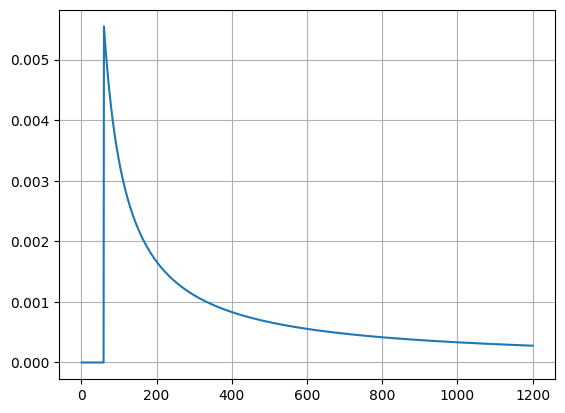

In [21]:
import numpy as np

# Observed maximum
m = 60

# Prior support for N -> The posterior changes with this!!
N_max = 1200  # adjust to test sensitivity
N = np.arange(1, N_max + 1)

# Likelihood p(m|N) = 1/N for N>=m else 0
lik = np.zeros_like(N, dtype=float)
lik[N >= m] = 1.0 / N[N >= m]

# Uniform prior over 1..N_max
prior = np.ones_like(N, dtype=float)

# Posterior (unnormalized) and normalize
post = lik * prior
post /= post.sum()

# Posterior summaries
mean_N = (N * post).sum()
median_N = N[np.searchsorted(np.cumsum(post), 0.5)]
hpd95_upper = N[np.searchsorted(np.cumsum(post), 0.95)]

# Tail probability P(N>1100 | m)
p_gt_1100 = post[N > 1100].sum()
print(f"Probability that N > 11100 given m = {m}: {p_gt_1100:.3f}")
print(f"Posterior mean: {mean_N:.2f}, median: {median_N}, 95% upper quantile: {hpd95_upper}")
print(f"Prob[N={N_max}] = {post[N_max-1]:.5f}")
plt.plot(N, post); plt.grid(True);

Expected number of correct identifications: 19.500


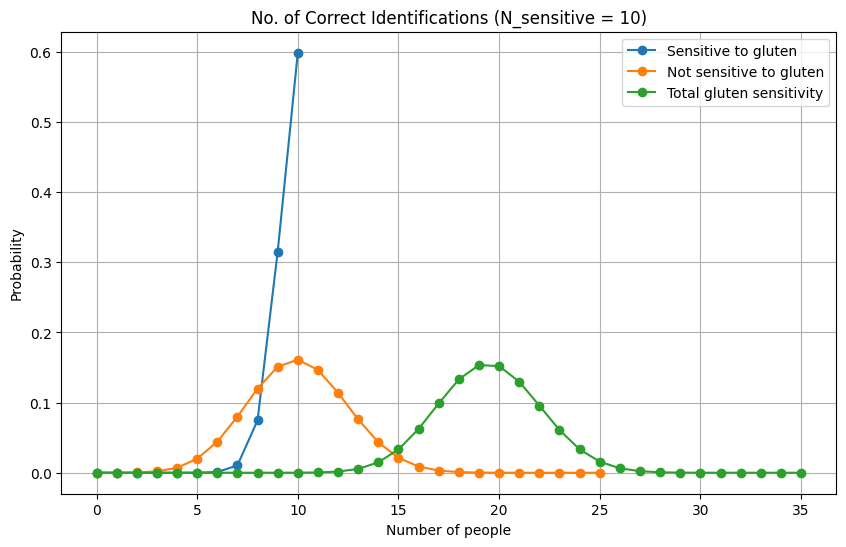

In [38]:
n = 35  # Number of people
ncorrect = 12  # Number of people with correct gluten test

num_sensitive = 10  # Number of people sensitive to gluten
prob_sensitive = .95

num_not_sensitive = n - num_sensitive  # Number of people not sensitive to gluten
prob_not_sensitive = .4

n_senstive = np.arange(0, num_sensitive + 1)
pmf_sensitive = stats.binom.pmf(n_senstive, num_sensitive, prob_sensitive)

n_insenstive = np.arange(0, num_not_sensitive + 1)
pmf_not_sensitive = stats.binom.pmf(n_insenstive, num_not_sensitive, prob_not_sensitive)

n_sum = np.arange(n_senstive[0] + n_insenstive[0], n_senstive[-1]+n_insenstive[-1] + 1)  # Create a grid for convolution
pmf_sum = np.convolve(pmf_sensitive, pmf_not_sensitive)

print(f"Expected number of correct identifications: {sum(n_sum*pmf_sum):.3f}")
plt.figure(figsize=(10, 6))
plt.plot(n_senstive, pmf_sensitive, '-o', label='Sensitive to gluten')
plt.plot(n_insenstive, pmf_not_sensitive, '-o', label='Not sensitive to gluten')
plt.plot(n_sum, pmf_sum, '-o', label='Total gluten sensitivity')
plt.title('No. of Correct Identifications (N_sensitive = 10)')
plt.xlabel('Number of people'); plt.ylabel('Probability'); plt.legend(); plt.grid(True); plt.show()

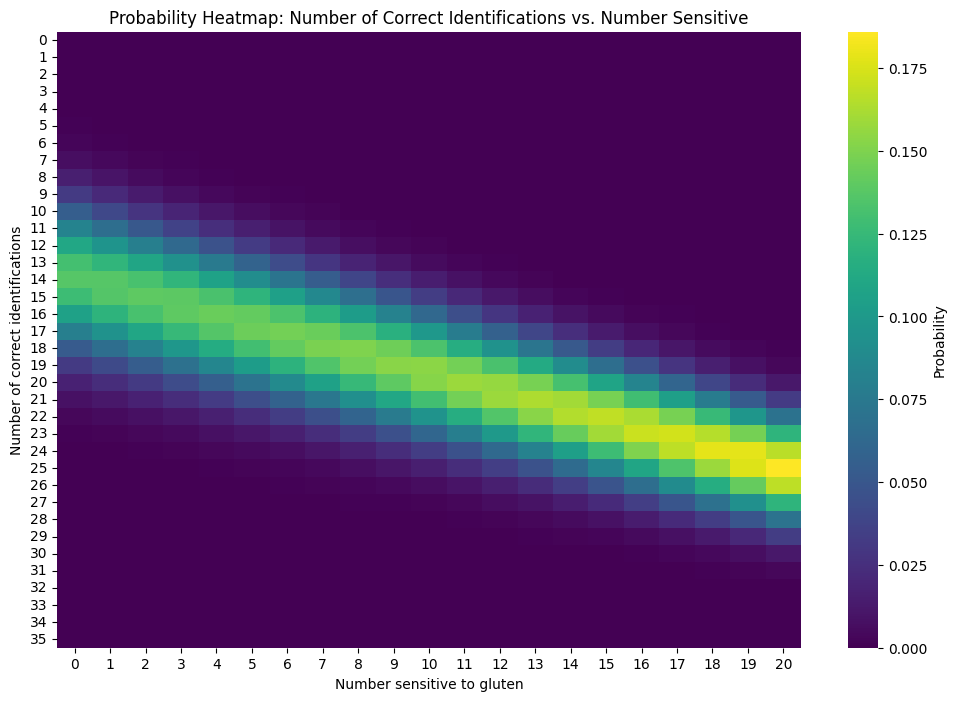

In [65]:
import pandas as pd
import seaborn as sns
n = 35  # Number of people

def posterior(num_sensitive):
    ncorrect = 12  # Number of people with correct gluten test

    prob_sensitive = .95
    prob_not_sensitive = .4

    num_not_sensitive = n - num_sensitive  # Number of people not sensitive to gluten

    n_senstive = np.arange(0, num_sensitive + 1)
    pmf_sensitive = stats.binom.pmf(n_senstive, num_sensitive, prob_sensitive)

    n_insenstive = np.arange(0, num_not_sensitive + 1)
    pmf_not_sensitive = stats.binom.pmf(n_insenstive, num_not_sensitive, prob_not_sensitive)

    n_sum = np.arange(n_senstive[0] + n_insenstive[0], n_senstive[-1]+n_insenstive[-1] + 1)  # Create a grid for convolution
    pmf_sum = np.convolve(pmf_sensitive, pmf_not_sensitive)
    # print(pmf_sum.sum()) # should be 1.0
    return n_sum, pmf_sum


df = pd.DataFrame()
range_sensitive = np.arange(0, 21)  # Range of number sensitive to gluten
for num_sensitive in range_sensitive:
    n_sum, pmf_sum = posterior(num_sensitive)
    df[num_sensitive] = pmf_sum
df.index = n_sum
df.index.name = 'Number of correct identifications'
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df, cmap='viridis', cbar_kws={'label': 'Probability'})
plt.title('Probability Heatmap: Number of Correct Identifications vs. Number Sensitive')
plt.ylabel('Number of correct identifications')
plt.xlabel('Number sensitive to gluten')
plt.show()

mean of post_12 =  2.3686988868489944


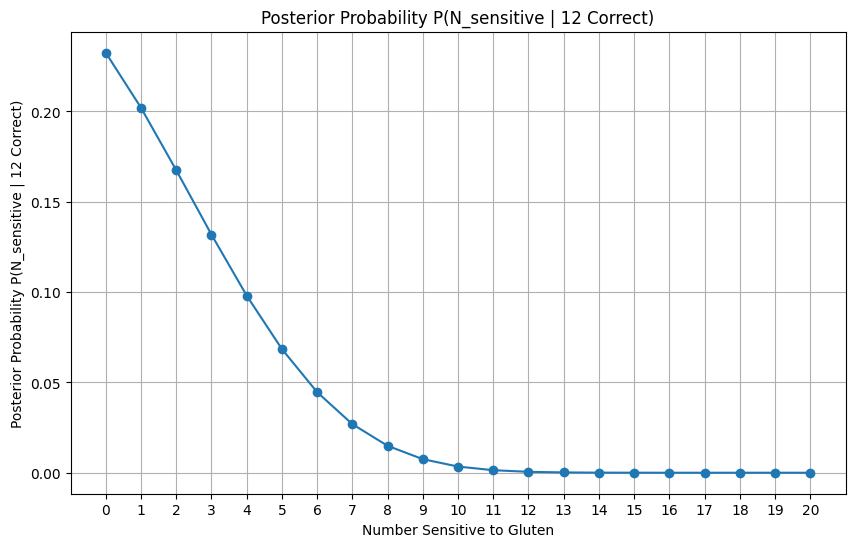

In [77]:
post_12 = df.loc[12] / df.loc[12].sum()  # Normalize the posterior for 12 correct identifications
print(f"mean of post_12 = ", sum(post_12 * range_sensitive))
plt.figure(figsize=(10, 6))
plt.plot(range_sensitive, post_12, '-o', label='Posterior for 12 Correct Identifications')
plt.title('Posterior Probability P(N_sensitive | 12 Correct)')
plt.xlabel('Number Sensitive to Gluten')
plt.ylabel('Posterior Probability P(N_sensitive | 12 Correct)')
plt.xticks(np.arange(0, 21, 1))
plt.grid(True)

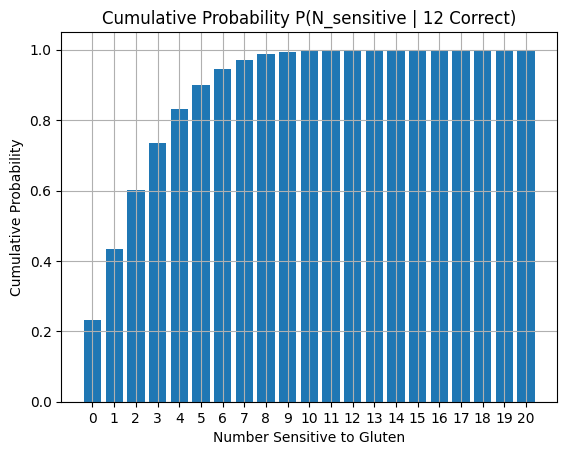

In [83]:
plt.bar(range_sensitive, np.cumsum(post_12), label='Cumulative Probability')
plt.title('Cumulative Probability P(N_sensitive | 12 Correct)')
plt.xticks(range_sensitive)
plt.xlabel('Number Sensitive to Gluten')
plt.ylabel('Cumulative Probability')
plt.grid(True);

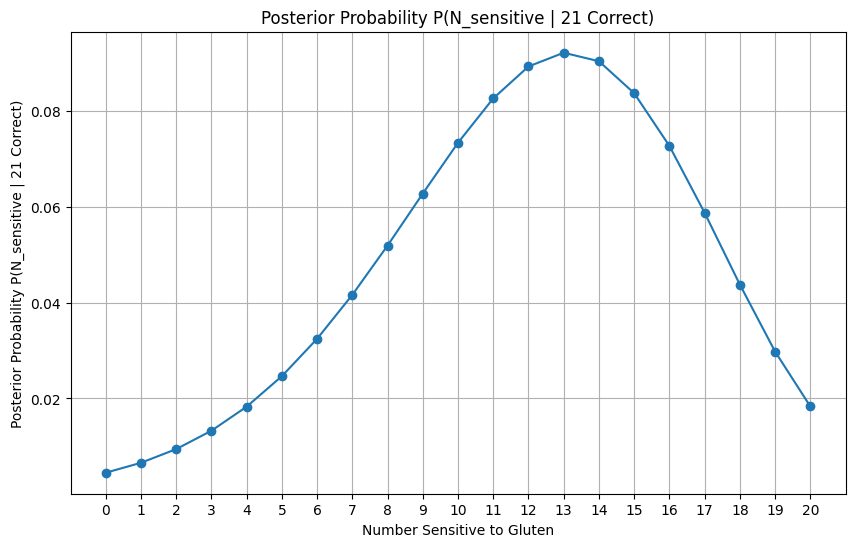

In [74]:
post = df.loc[21] / df.loc[21].sum()  # Normalize the posterior for 12 correct identifications
plt.figure(figsize=(10, 6))
plt.plot(range_sensitive, post, '-o', label='Posterior for 21 Correct Identifications')
plt.title('Posterior Probability P(N_sensitive | 21 Correct)')
plt.xlabel('Number Sensitive to Gluten')
plt.ylabel('Posterior Probability P(N_sensitive | 21 Correct)')
plt.xticks(np.arange(0, 21, 1))
plt.grid(True)

### D&D goblin defeat probability after 3 damage
Let H be goblin HP ~ 2d6 (sums 2..12). Given the goblin is still alive after 3 damage, we condition on H ≥ 4. On the next attack, damage X ~ 1d6, and defeat occurs if X ≥ H − 3.

Thus
P(defeat next | 3 dmg) = Σ_{h=4}^{12} P(H=h | H≥4) · P(X ≥ h−3)
with P(H=h) ∝ [1,2,3,4,5,6,5,4,3,2,1] for h=2..12 and P(X ≥ t) =
1 if t ≤ 1; (7−t)/6 for t∈{2..6}; 0 if t > 6.

The weighted sum equals 15/33 = 5/11 ≈ 0.4545.

In [107]:
d6 = np.ones(6) / 6  # Probability of each face on a fair die
d6 = pd.Series(d6, index=np.arange(1, 7))  # Create a Series for easier indexing

goblin_prob = np.convolve(d6, d6)  # Convolve the probabilities of two dice
# print(goblin_prob, goblin_prob.shape, goblin_range.shape)
goblin_range = np.arange(2, 12+1) # result of convolution is 2..12
gprob = pd.Series(goblin_prob, index=goblin_range)
# print(gprob)
hit = 3
hit_range = np.arange(1, 7)  # faces 1..6 inclusive

# P(gh|still alive after hit) = P(gh | hit=3)
gprob[goblin_range <= hit] = 0  # Set probabilities for goblins with hit points <= hit to 0
gprob = gprob / gprob.sum()  # Normalize the probabilities
print(gprob, gprob.sum())

# P(Kill goblin | still alive after hit) = \sum_{h=1}^6 P(kill|gh, hit=3) P(gh|hit=3)
# P(kill|gh, hit=3) = P(roll + hit >= gh)
psum = 0
p = 0
for gh, gp in gprob.items():
    if gh <= hit:
        continue
    p = 0
    for h in hit_range:
        if hit + h >= gh:
            p += d6[h]  # index shift: face h maps to d6[h-1]
    print(f"Probability of killing goblin of {gh} is {p:.4f}", end=' ')
    p *= gp
    psum += p
    print(f"p*{gp:.4f} = {p:.4f} => cumulative {psum:.4f}")
print(f"Overall probability (next hit defeats) = {psum:.6f} (~ {psum:.4f})")

[0.02777778 0.05555556 0.08333333 0.11111111 0.13888889 0.16666667
 0.13888889 0.11111111 0.08333333 0.05555556 0.02777778] (11,) (11,)
2     0.000000
3     0.000000
4     0.090909
5     0.121212
6     0.151515
7     0.181818
8     0.151515
9     0.121212
10    0.090909
11    0.060606
12    0.030303
dtype: float64 0.9999999999999999
Probability of killing goblin of 4 is 1.0000 p*0.0909 = 0.0909 => cumulative 0.0909
Probability of killing goblin of 5 is 0.8333 p*0.1212 = 0.1010 => cumulative 0.1919
Probability of killing goblin of 6 is 0.6667 p*0.1515 = 0.1010 => cumulative 0.2929
Probability of killing goblin of 7 is 0.5000 p*0.1818 = 0.0909 => cumulative 0.3838
Probability of killing goblin of 8 is 0.3333 p*0.1515 = 0.0505 => cumulative 0.4343
Probability of killing goblin of 9 is 0.1667 p*0.1212 = 0.0202 => cumulative 0.4545
Probability of killing goblin of 10 is 0.0000 p*0.0909 = 0.0000 => cumulative 0.4545
Probability of killing goblin of 11 is 0.0000 p*0.0606 = 0.0000 => cumulativ

PMF length: 16, sum=1.000
E[sum of best 3 of 4d6] ≈ 9.235


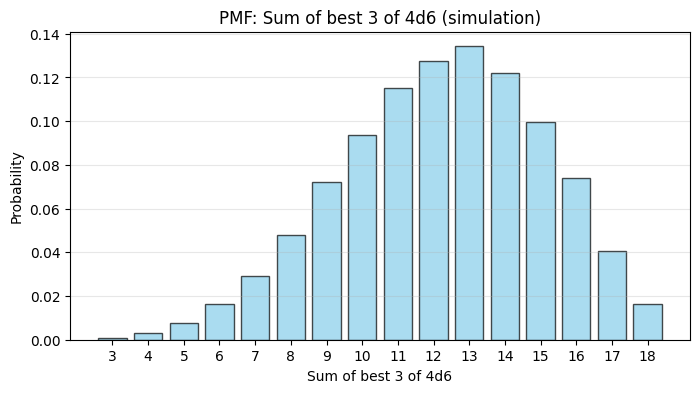

In [134]:
nrolls = 100000

# Simulate nrolls sets of 4d6
rolls = np.random.randint(1, 7, size=(nrolls, 4))
# Sum of best 3 of 4 = sum of all 4 minus the minimum
score = rolls.sum(axis=1) - rolls.min(axis=1)

# PMF over scores (support 3..18)
index, _, count = np.unique(score, return_counts=True, return_index=True)
# Create a Series for easier indexing
pmf = pd.Series(count/nrolls, name='Sum of best 3 of 4d6', index=index)  # Create a Series for easier indexing
# pmf = np.bincount(score, minlength=19)
# pmf = pmf / pmf.sum()
print(f"PMF length: {len(pmf)}, sum={pmf.sum():.3f}")

# Expected value
support = np.arange(len(pmf))
expected = (support * pmf).sum()
print(f"E[sum of best 3 of 4d6] ≈ {expected:.3f}")

# Plot PMF
plt.figure(figsize=(8,4))
plt.bar(pmf.index, pmf.values, width=0.8, color='skyblue', edgecolor='black', alpha=0.7)
plt.xticks(np.arange(3, 19))
plt.xlabel('Sum of best 3 of 4d6')
plt.ylabel('Probability')
plt.title('PMF: Sum of best 3 of 4d6 (simulation)')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

Text(0, 0.5, 'Cumulative Probability')

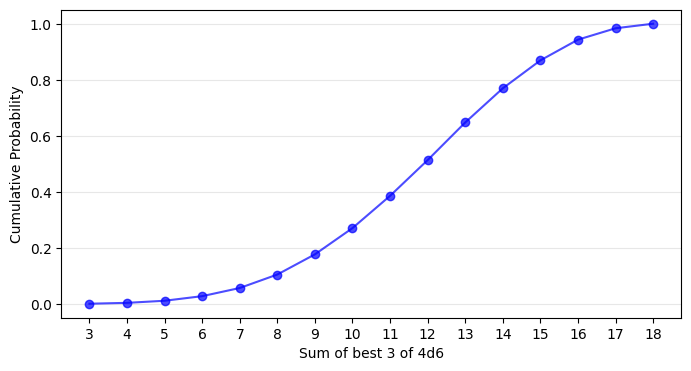

In [135]:
cdf = pmf.cumsum()
plt.figure(figsize=(8,4))
plt.plot(cdf.index, cdf.values, marker='o', linestyle='-', color='blue', alpha=0.7)
plt.xticks(np.arange(3, 19)); plt.grid(True, axis='y', alpha=0.3)
plt.xlabel('Sum of best 3 of 4d6')
plt.ylabel('Cumulative Probability')

## MAX out of Six
Now we sample six values $X_1, ..., X_6$ from the pmf.
$$
M = max[X_1, ..., X_6] 
$$

What is $p_M(m)$ or $F_M(m) = CDF(m) = Pr[M <= m]$?

$$
M = max[X_1, ..., X_6] \leq m
$$
means that all of them are less than $m$.
\begin{align}
Pr[M <= m] & = Pr[X_1 \leq m , X_2 \leq m, ..., X_6 \leq m] \\
        & = Pr[X_1 \leq m] ... Pr[X_6 \leq m] \\
    &= Pr[X \leq m]^6
\end{align}

$$
P[M = m] = Pr[M\leq m]^6 - Pr[M\leq m-1]^6
$$


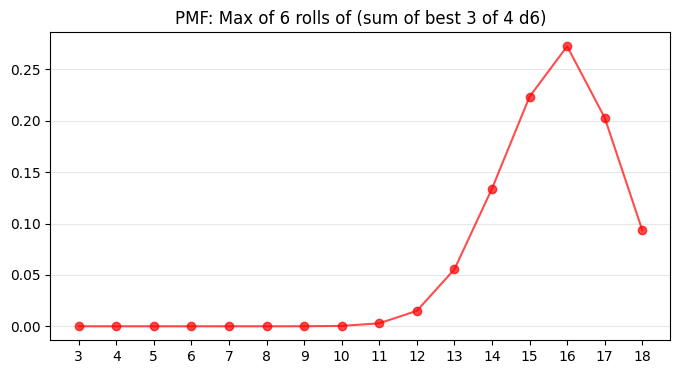

In [138]:
cdf_max = cdf**6
pmf_max = np.diff(cdf_max, prepend=0)  # Compute PMF from CDF
plt.figure(figsize=(8,4))
plt.plot(cdf.index, pmf_max, marker='o', linestyle='-', color='red', alpha=0.7)
plt.xticks(np.arange(3, 19)); plt.grid(True, axis='y', alpha=0.3)
plt.title('PMF: Max of 6 rolls of (sum of best 3 of 4 d6)');

## MIN out of Six
Now we sample six values $X_1, ..., X_6$ from the pmf.
$$
Y = min[X_1, ..., X_6]
$$

What is $p(m)$ or $F(m) = CDF(m) = Pr[Y <= m]$?

$$
M = min[X_1, ..., X_6] \leq m
$$
means that some of them is less than or equal to $m$;

This is the complement of every of them is larger than $m$: 

\begin{align}
Pr[Y\leq m] & = 1 - Pr[Y > m] \\
            & = 1 - Pr[Y \geq m+1] \\
            & = 1 - Pr[X_1 > m] \cdot Pr[X_2 > m] \cdot ... \cdot Pr[X_6 > m] \\
            & = 1 - (1 - Pr[X_1 \leq m]) \cdot (1 - Pr[X_2 \leq m] ...) \\
            & = 1 - (1 - Pr[X \leq m])^6
\end{align}


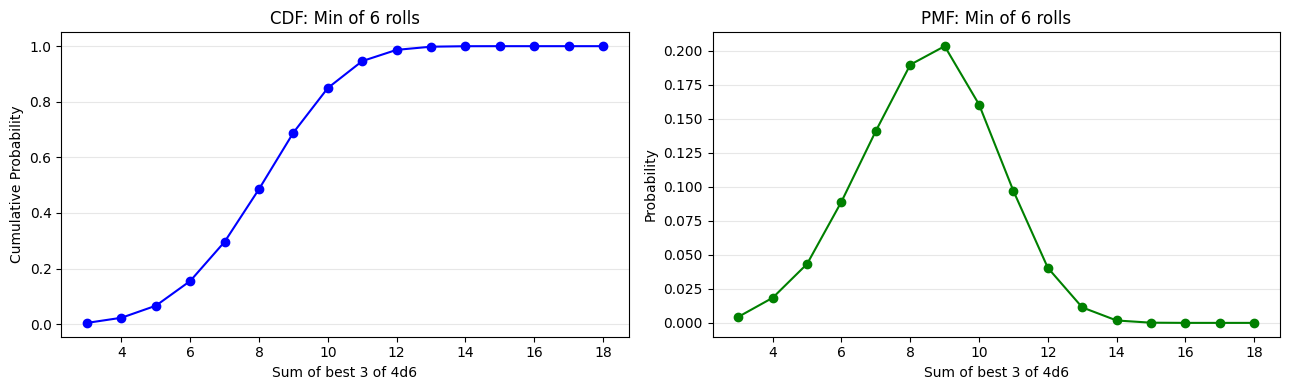

In [147]:
cdf_min = 1 - (1 - cdf)**6
pmf_min = np.diff(cdf_min, prepend=0)  # Compute PMF

fig, axs = plt.subplots(1, 2, figsize=(13, 4))
axs[0].plot(cdf_min.index, cdf_min.values, marker='o', color='blue')
axs[0].set_title('CDF: Min of 6')
axs[0].set_xlabel('Sum of best 3 of 4d6')
axs[0].set_ylabel('Cumulative Probability')
axs[0].grid(True, axis='y', alpha=0.3)

axs[1].plot(cdf_min.index, pmf_min, marker='o', color='green')
axs[1].set_title('PMF: Min of 6')
axs[1].set_xlabel('Sum of best 3 of 4d6')
axs[1].set_ylabel('Probability')
axs[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

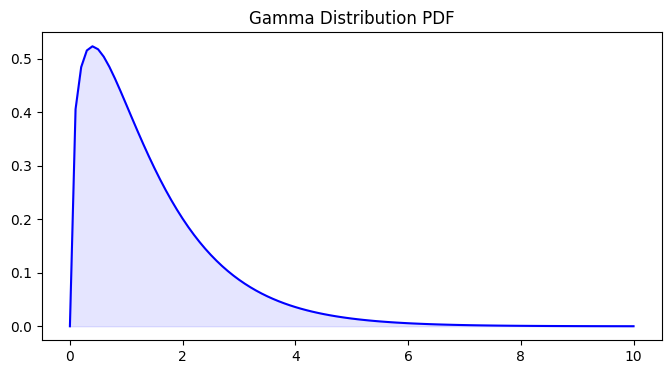

In [157]:
from scipy.stats import gamma

alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs) # From the book TB2 (scale=1 is default)

# Plot the Gamma PDF
plt.figure(figsize=(8, 4))
plt.plot(qs, ps, label=f'Gamma PDF (α={alpha})', color='blue')
plt.fill_between(qs, ps, color='blue', alpha=0.1)   
plt.title('Gamma Distribution PDF');


mean of Gamma PDF: 1.40, variance: 1.40


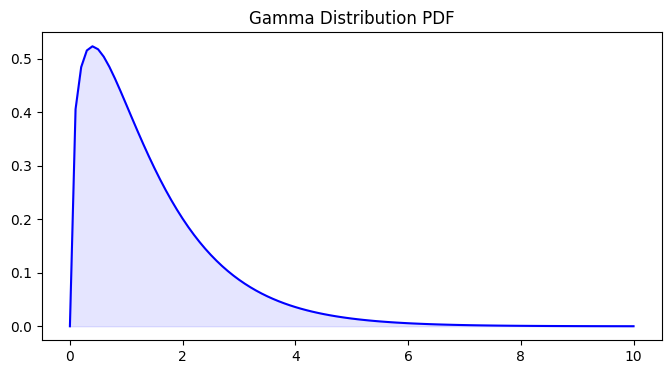

In [158]:
from scipy.stats import gamma

alpha = 1.4 # Shape parameter for the Gamma distribution
qs = np.linspace(0, 10, 101)
ps = gamma(alpha, scale=1).pdf(qs)  # TB2 with scale=1 specified
print(f"mean of Gamma PDF: {gamma(alpha, scale=1).mean():.2f}, variance: {gamma(alpha, scale=1).var():.2f}")
# Plot the Gamma PDF
plt.figure(figsize=(8, 4))
plt.plot(qs, ps, label=f'Gamma PDF (α={alpha})', color='blue')
plt.fill_between(qs, ps, color='blue', alpha=0.1)   
plt.title('Gamma Distribution PDF');


## Gamma distribution (shape–scale parameterization)
- Support: x > 0
- Parameters: shape α > 0, scale θ > 0 (rate β = 1/θ)
- PDF: f(x; α, θ) = x^{α−1} e^{−x/θ} / (Γ(α) θ^{α})
- Mean: E[X] = αθ; Variance: Var[X] = αθ²
- Special cases: α = 1 gives Exponential(θ); 2·Gamma(α=k/2, θ=2) is χ²_k.
- Conjugacy: Gamma prior on rate is conjugate to Poisson and Exponential likelihoods.

SciPy notes: scipy.stats.gamma uses shape parameter a=α and scale=θ (with optional loc).

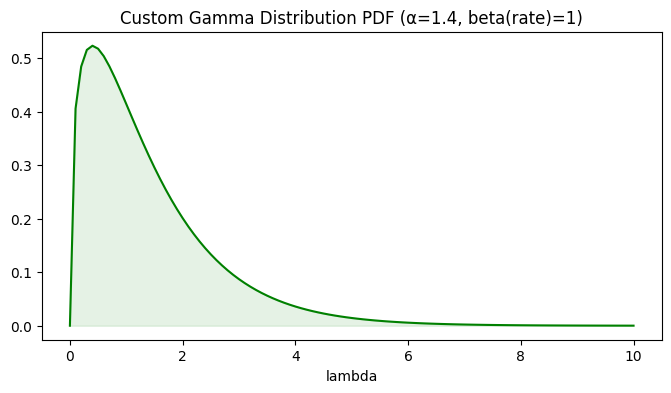

In [172]:
from scipy.special import gamma as gamma_func

def gamma_pdf(x, alpha, rate=1):
    """
    Compute the PDF of the Gamma distribution at x.
    Parameters:
        x : array-like or float
        alpha : shape parameter
        rate : rate parameter (default=1)
        --> theta = 1/rate
    Returns:
        pdf : array-like or float
    """
    x = np.asarray(x)
    theta = 1 / rate  # Scale parameter
    pdf = (x ** (alpha - 1)) * np.exp(-x / theta) / (gamma_func(alpha) * theta ** alpha)
    pdf[x < 0] = 0  # PDF is zero for x < 0
    return pdf

alpha = 1.4  # Shape parameter for the custom Gamma distribution
rate = 1  # Scale parameter, prior
gp = gamma_pdf(qs, alpha, rate=rate)
# Plot the custom Gamma PDF
plt.figure(figsize=(8, 4))
plt.plot(qs, gp, label=f'Custom Gamma PDF', color='green')
plt.fill_between(qs, gp, color='green', alpha=0.1)
plt.title(f'Custom Gamma Distribution PDF (α={alpha}, beta(rate)=1)');
plt.xlabel('lambda');

### Poisson–Gamma conjugate posterior (worked example)
- Likelihood: y | λ ~ Poisson(λ), observed y = 4
- Prior (shape–scale): λ ~ Gamma(α=1.4, \beta =1)
- Posterior (shape–scale): λ | y ~ Gamma(α+ y, θ_post), with θ_post = 1 / (1/θ + 1)
  - α_post = 1.4 + 4 = 5.4
  - θ_post = 1 / (1 + 1) = 0.5
- Posterior moments:
  - E[λ | y] = α_post · θ_post = 5.4 · 0.5 = 2.7
  - Var[λ | y] = α_post · θ_post² = 5.4 · 0.25 = 1.35

The notebook cells above compute and plot the prior and posterior densities accordingly.

Posterior: Gamma(shape=5.400, rate=2.000)
Posterior mean = 2.700, var = 1.350


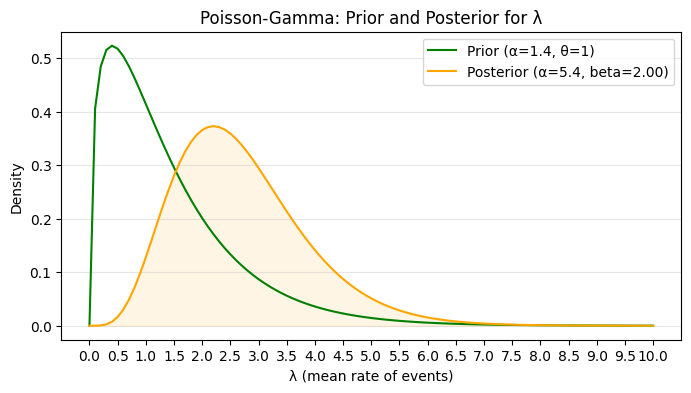

In [179]:
# Bayesian Inference (Poisson-Gamma conjugacy)
# Prior: lambda ~ Gamma(alpha, theta) in shape-scale
# Likelihood: y ~ Poisson(lambda), single observation y=outcome
# Posterior: lambda | y ~ Gamma(alpha+ y, theta_post) with theta_post = 1 / (1/theta + 1)

n_games = 1  # number of Poisson observations (exposures), here 1
outcome = 4  # observed count

alpha_update = alpha + outcome  # shape updates additively by the count
# Scale updates via rates additivity: 1/theta_post = 1/theta + n
rate_update = rate + n_games

print(f"Posterior: Gamma(shape={alpha_update:.3f}, rate={rate_update:.3f})")
print(f"Posterior mean = {alpha_update/rate_update:.3f}, var = {alpha_update/rate_update**2:.3f}")

# Posterior PDF after observing the outcome
posterior_pdf = gamma_pdf(qs, alpha_update, rate_update)

# Plot prior vs posterior
plt.figure(figsize=(8, 4))
plt.plot(qs, gp, label=f'Prior (α={alpha}, θ={theta})', color='green')
plt.plot(qs, posterior_pdf, label=f'Posterior (α={alpha_update:.1f}, beta={rate_update:.2f})', color='orange')
plt.fill_between(qs, posterior_pdf, color='orange', alpha=0.1)
plt.title('Poisson-Gamma: Prior and Posterior for λ')
plt.xlabel('λ (mean rate of events)'); plt.xticks(np.linspace(0, 10, 21))
plt.ylabel('Density')
plt.legend(); plt.grid(True, axis='y', alpha=0.3)

54 years of snow data


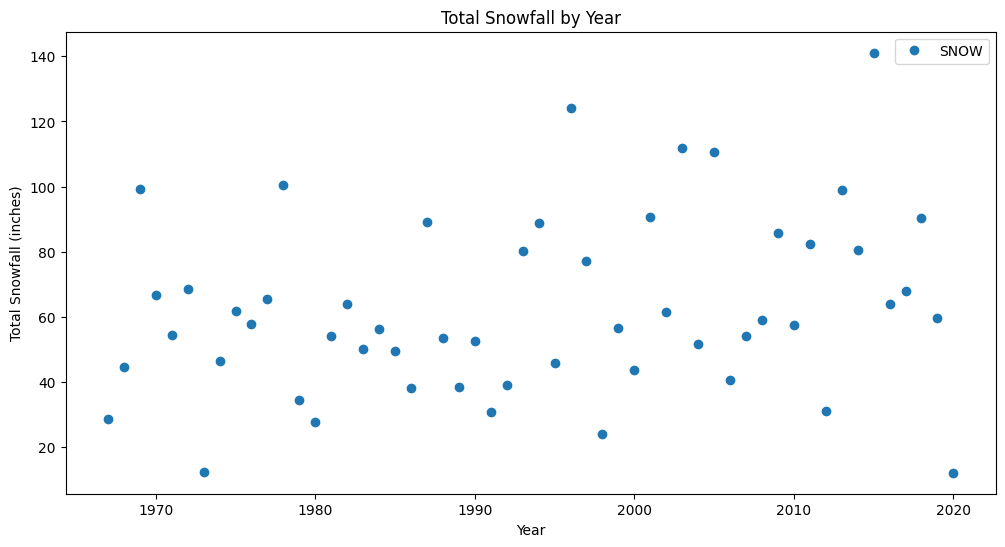

In [275]:
csvfile = 'https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2239075.csv'
df_csv = pd.read_csv(csvfile, parse_dates=[2])
df_csv['YEAR'] = df_csv['DATE'].dt.year
snow = df_csv.groupby('YEAR')['SNOW'].sum().reset_index()

print(len(snow), "years of snow data")
snow.plot(x='YEAR', y='SNOW', ls='', marker='o', figsize=(12, 6), title='Total Snowfall by Year')
plt.xlabel('Year'); plt.ylabel('Total Snowfall (inches)');

Kolmogorov-Smirnov Distance: 0.1143


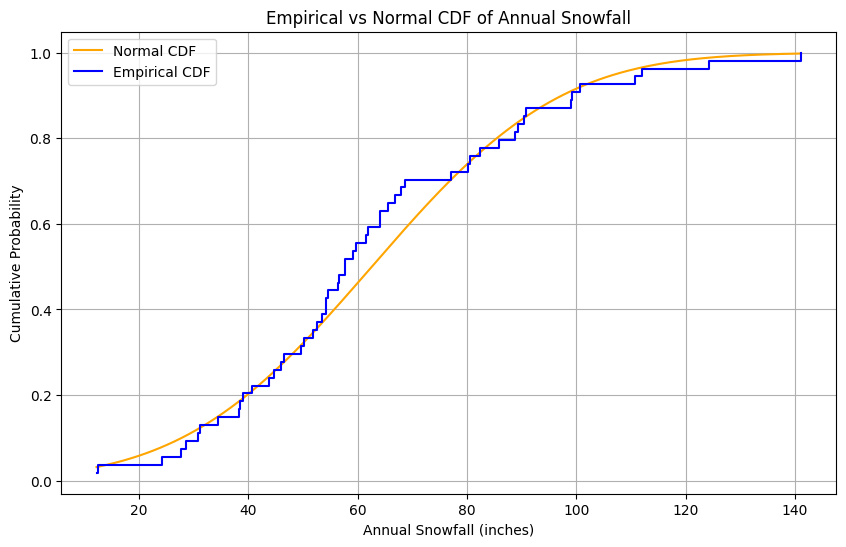

In [286]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm

# Use the annual SNOW totals
data = snow['SNOW'].values

# Empirical CDF
ecdf = ECDF(data)

# Normal CDF with sample mean and std
mu, sigma = data.mean(), data.std()
x = np.linspace(data.min(), data.max(), 200)
cdf_norm = norm.cdf(x, loc=mu, scale=sigma)

ks_dist = np.max( np.abs( norm.cdf(data, loc=mu, scale=sigma) - ecdf(data) ) )  # Difference between the two CDFs
print(f"Kolmogorov-Smirnov Distance: {ks_dist:.4f}")

# Plot both CDFs
plt.figure(figsize=(10, 6))
plt.plot(x, cdf_norm, label='Normal CDF', color='orange')
plt.step(np.sort(data), ecdf(np.sort(data)), where='post', label='Empirical CDF', color='blue')
plt.xlabel('Annual Snowfall (inches)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical vs Normal CDF of Annual Snowfall')
plt.legend()
plt.grid(True)
plt.show()

### 1. Kolmogorov–Smirnov (KS) Distance
- Measures the maximum vertical distance between two CDFs.

- Simple and widely used for comparing empirical and theoretical distributions.

- Limitation: Doesn't consider how far apart the values are — just the largest gap.

    ```
    from scipy.stats import kstest, norm
    # Example: compare empirical data to normal distribution
    ks_stat, p_value = kstest(data, 'norm', args=(mean, std))
    ```

### 4. Earth Mover’s Distance (Wasserstein Distance)
- Can be interpreted as the area between two CDFs.
- Takes into account the actual distances between values, unlike KS.
    ```
    from scipy.stats import wasserstein_distance
    distance = wasserstein_distance(data, norm.rvs(loc=mean, scale=std, size=len(data)))
    ```

In [281]:
from scipy.stats import kstest, norm

# Example: compare empirical data to normal distribution
ks_stat, p_value = kstest(data, 'norm', args=(mu, sigma))
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

from scipy.stats import wasserstein_distance

distance = wasserstein_distance(data, norm.rvs(loc=mu, scale=sigma, size=len(data)))
print(f"Wasserstein Distance: {distance:.4f}")

KS Statistic: 0.1143, p-value: 0.4475
Wasserstein Distance: 7.8550


In [303]:
data = snow.reset_index()
offset = round(data['YEAR'].mean())  # Use the mean year as offset
data['x'] = data['YEAR'] - offset  # Center the year data around the
data['y'] = data['SNOW']

print(f"Offset for x: {offset}")
print(data.head(2))


Offset for x: 1994
   index  YEAR  SNOW   x     y
0      0  1967  28.6 -27  28.6
1      1  1968  44.7 -26  44.7


In [293]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
model = smf.ols(formula, data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.277
Date:                Sun, 17 Aug 2025   Prob (F-statistic):             0.0760
Time:                        12:52:38   Log-Likelihood:                -253.22
No. Observations:                  54   AIC:                             510.4
Df Residuals:                      52   BIC:                             514.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.7805      3.652     17.192      0.0

In [297]:
# Standard deviation of residuals between observed and predicted values
model.resid.std()

np.float64(26.566114647742996)

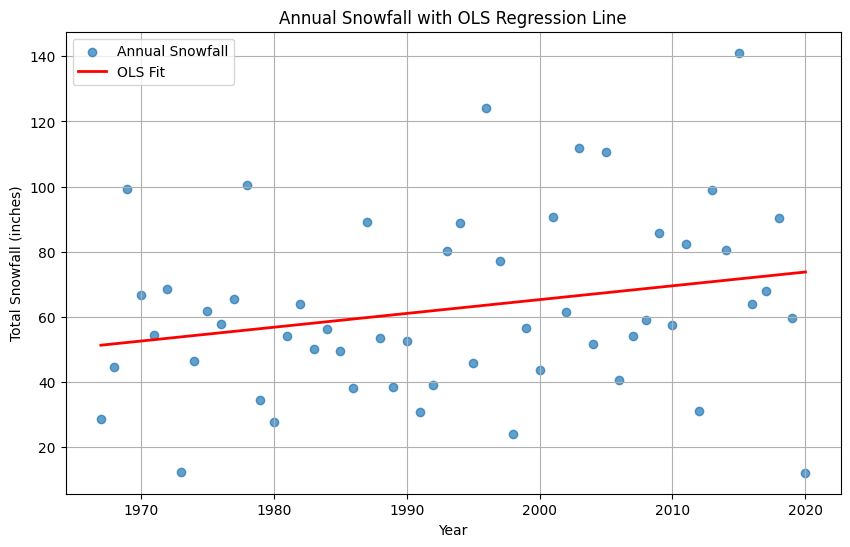

In [298]:
plt.figure(figsize=(10, 6))
plt.scatter(data['YEAR'], data['SNOW'], alpha=0.7, label='Annual Snowfall')
plt.plot(data['YEAR'], model.fittedvalues, color='red', linewidth=2, label='OLS Fit')
plt.xlabel('Year')
plt.ylabel('Total Snowfall (inches)')
plt.title('Annual Snowfall with OLS Regression Line')
plt.legend()
plt.grid(True)
plt.show()

Slope: 0.42394129979035655 Intercept: 62.7804891684137


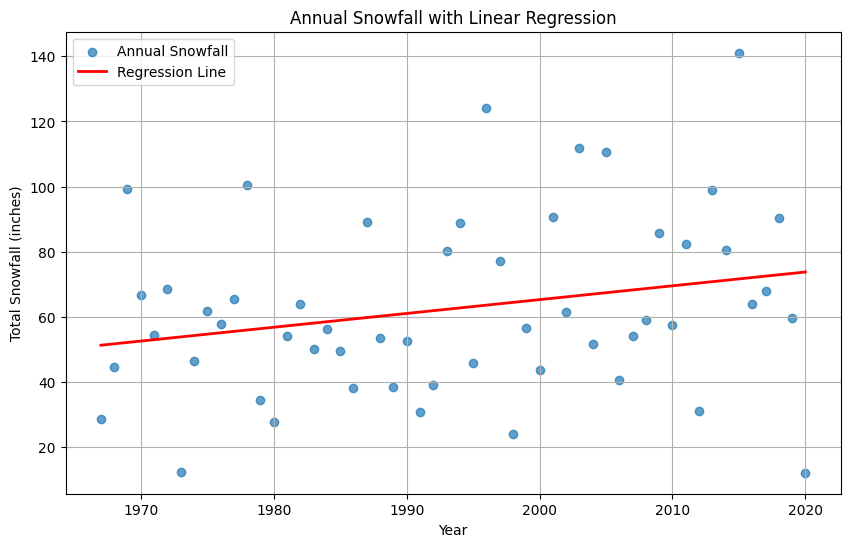

In [309]:
from scipy.stats import linregress
result = linregress(data.x, data.y)  # Perform linear regression

print("Slope:", result.slope, "Intercept:", result.intercept)
y_pred = result.intercept + result.slope * data.x
plt.figure(figsize=(10, 6))
plt.scatter(data.x + offset, data.y, alpha=0.7, label='Annual Snowfall')
plt.plot(data.x + offset, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Year'); plt.ylabel('Total Snowfall (inches)'); 
plt.title('Annual Snowfall with Linear Regression')
plt.legend(); plt.grid(True); plt.show()

OLS Parameters: a = 0.424, b = 62.780


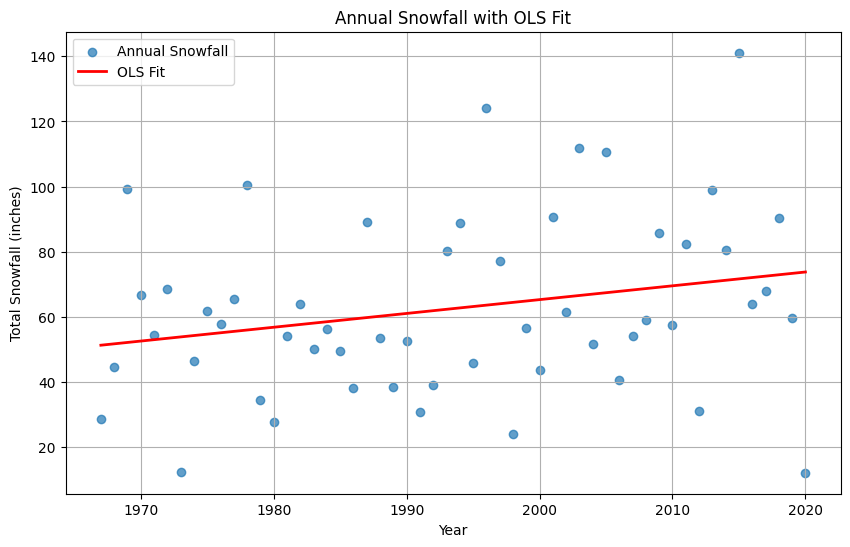

In [315]:
# y = a x + b = [x, 1] [a; b]

X = np.zeros((len(data), 2))
X[:, 0] = data['x']  # Centered year
X[:, 1] = 1.  # Intercept term
y = data['y'].values 

param =  np.linalg.lstsq(X, y, rcond=None)[0]  # Solve for parameters a and b
param = np.linalg.inv(X.T @ X) @ X.T @ y  # Alternative way to compute OLS parameters
a, b = param
print(f"OLS Parameters: a = {a:.3f}, b = {b:.3f}")

plt.figure(figsize=(10, 6))
plt.scatter(data['x'] + offset, data['y'], alpha=0.7, label='Annual Snowfall')
plt.plot(data['x'] + offset, param[0] * data['x'] + param[1], color='red', linewidth=2, label='OLS Fit')
plt.xlabel('Year'); plt.ylabel('Total Snowfall (inches)');
plt.title('Annual Snowfall with OLS Fit')
plt.legend(); plt.grid(True); plt.show()

In [316]:
mu, sigma, a, b

(np.float64(62.56851851851852),
 np.float64(27.135720779991402),
 np.float64(0.42394129979035666),
 np.float64(62.78048916841371))

In [328]:
# my prior for distribution of sigma = Gamma(shape, rate)
sigma = model.resid.std()  # Standard deviation of residuals
print(f"Estimated noise standard deviation (sigma): {sigma:.3f}")
sigma_mean = sigma 
sigma_std = sigma / 5 
gamma_shape = (sigma_mean / sigma_std) ** 2
gamma_rate = sigma_mean / sigma_std ** 2
print(f"Gamma prior parameters: shape = {gamma_shape:.3f}, rate = {gamma_rate:.3f} for mean= {sigma_mean:.3f}, std = {sigma_std:.3f}")

stan_code = """
data {
    real<lower=0> gamma_shape;  // shape parameter for Gamma prior
    real<lower=0> gamma_rate;   // rate parameter for Gamma prior

    int<lower=0> N;         // number of data points
    vector[N] x;            // predictor
    vector[N] y;            // response
}
parameters {
    real a;                 // slope
    real b;                 // intercept
    real<lower=0> sigma;    // noise stddev
}
model {
    a ~ normal(0, 2);  // prior for slope
    b ~ normal(62, 20);  // prior for intercept
    sigma ~ gamma(gamma_shape, gamma_rate);  // prior for noise stddev
    y ~ normal(a * x + b, sigma);
}
"""
print(stan_code)

Estimated noise standard deviation (sigma): 26.566
Gamma prior parameters: shape = 25.000, rate = 0.941 for mean= 26.566, std = 5.313

data {
    real<lower=0> gamma_shape;  // shape parameter for Gamma prior
    real<lower=0> gamma_rate;   // rate parameter for Gamma prior

    int<lower=0> N;         // number of data points
    vector[N] x;            // predictor
    vector[N] y;            // response
}
parameters {
    real a;                 // slope
    real b;                 // intercept
    real<lower=0> sigma;    // noise stddev
}
model {
    a ~ normal(0, 2);  // prior for slope
    b ~ normal(62, 20);  // prior for intercept
    sigma ~ gamma(gamma_shape, gamma_rate);  // prior for noise stddev
    y ~ normal(a * x + b, sigma);
}



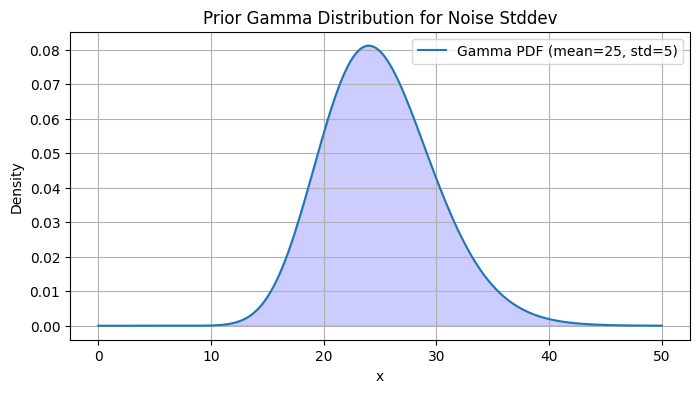

In [338]:
from scipy.stats import gamma
import numpy as np

import matplotlib.pyplot as plt

# Given mean and std
mean = 25
std = 5

# Gamma distribution: mean = alpha * scale, std = sqrt(alpha) * scale
# Solve for alpha and scale
shape = mean**2 / std**2
rate = mean / std**2

x = np.linspace(0, mean + 5*std, 200)
pdf = gamma(shape, scale=1/rate).pdf(x)  # scale = 1/rate is the same as rate = 1/scale

plt.figure(figsize=(8, 4))
plt.plot(x, pdf, label=f'Gamma PDF (mean={mean}, std={std})')
plt.fill_between(x, pdf, color='blue', alpha=0.2)
plt.title('Prior Gamma Distribution for Noise Stddev')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [339]:
from cmdstanpy import CmdStanModel
import numpy as np

# Prepare data for Stan
stan_data = {
    'gamma_shape': float(gamma_shape),
    'gamma_rate': float(gamma_rate),
    'N': len(data),
    'x': data['x'].values.astype(float),
    'y': data['y'].values.astype(float)
}

# Write Stan model to file
with open('snow_regression.stan', 'w') as f:
    f.write(stan_code)

# Compile Stan model
model = CmdStanModel(stan_file='snow_regression.stan')

# Sample from posterior
fit = model.sample(data=stan_data, chains=4, iter_sampling=1000, iter_warmup=500, seed=42)

# Extract posterior samples
samples = fit.draws_pd()

17:28:49 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\snow_regression.stan to exe file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\snow_regression.exe
17:28:58 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\snow_regression.exe
17:28:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


17:29:00 - cmdstanpy - INFO - CmdStan done processing.
17:29:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'snow_regression.stan', line 18, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'snow_regression.stan', line 18, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'snow_regression.stan', line 18, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'snow_regression.stan', line 18, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'snow_regression.stan', line 18, column 4 to column 43)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'snow_regression.stan', line 18, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must b

In [340]:
print(samples.head())

   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -147.633       1.000000     0.71466          3.0   
1      1.0     2.0     2.0 -147.449       0.956299     0.71466          3.0   
2      1.0     3.0     3.0 -147.213       0.958425     0.71466          3.0   
3      1.0     4.0     4.0 -147.917       0.936228     0.71466          3.0   
4      1.0     5.0     5.0 -148.010       0.998287     0.71466          3.0   

   n_leapfrog__  divergent__  energy__         a        b    sigma  
0           7.0          0.0   148.010  0.716957  64.4792  27.5672  
1           7.0          0.0   148.796  0.533657  66.9917  26.5797  
2           7.0          0.0   148.611  0.301860  59.3147  26.7259  
3           7.0          0.0   148.350  0.222022  57.8110  27.0589  
4           7.0          0.0   148.413  0.649352  67.5157  26.3208  


In [334]:
print(samples[['a', 'b', 'sigma']].describe())  # Summary statistics for parameters

ci_a = np.percentile(samples['a'], [5, 95])
ci_b = np.percentile(samples['b'], [5, 95])
ci_sigma = np.percentile(samples['sigma'], [5, 95])
print(f"90% credible interval for a: {ci_a[0]:.3f} to {ci_a[1]:.3f}")
print(f"90% credible interval for b: {ci_b[0]:.3f} to {ci_b[1]:.3f}")
print(f"90% credible interval for sigma: {ci_sigma[0]:.3f} to {ci_sigma[1]:.3f}")

                 a            b        sigma
count  4000.000000  4000.000000  4000.000000
mean      0.414277    62.715698    26.946486
std       0.230137     3.491446     2.357673
min      -0.559876    50.667900    20.064300
25%       0.262737    60.277650    25.305975
50%       0.412929    62.713600    26.818050
75%       0.567847    65.039750    28.405575
max       1.288310    77.292100    36.302700
90% credible interval for a: 0.051 to 0.793
90% credible interval for b: 57.012 to 68.554
90% credible interval for sigma: 23.310 to 31.103


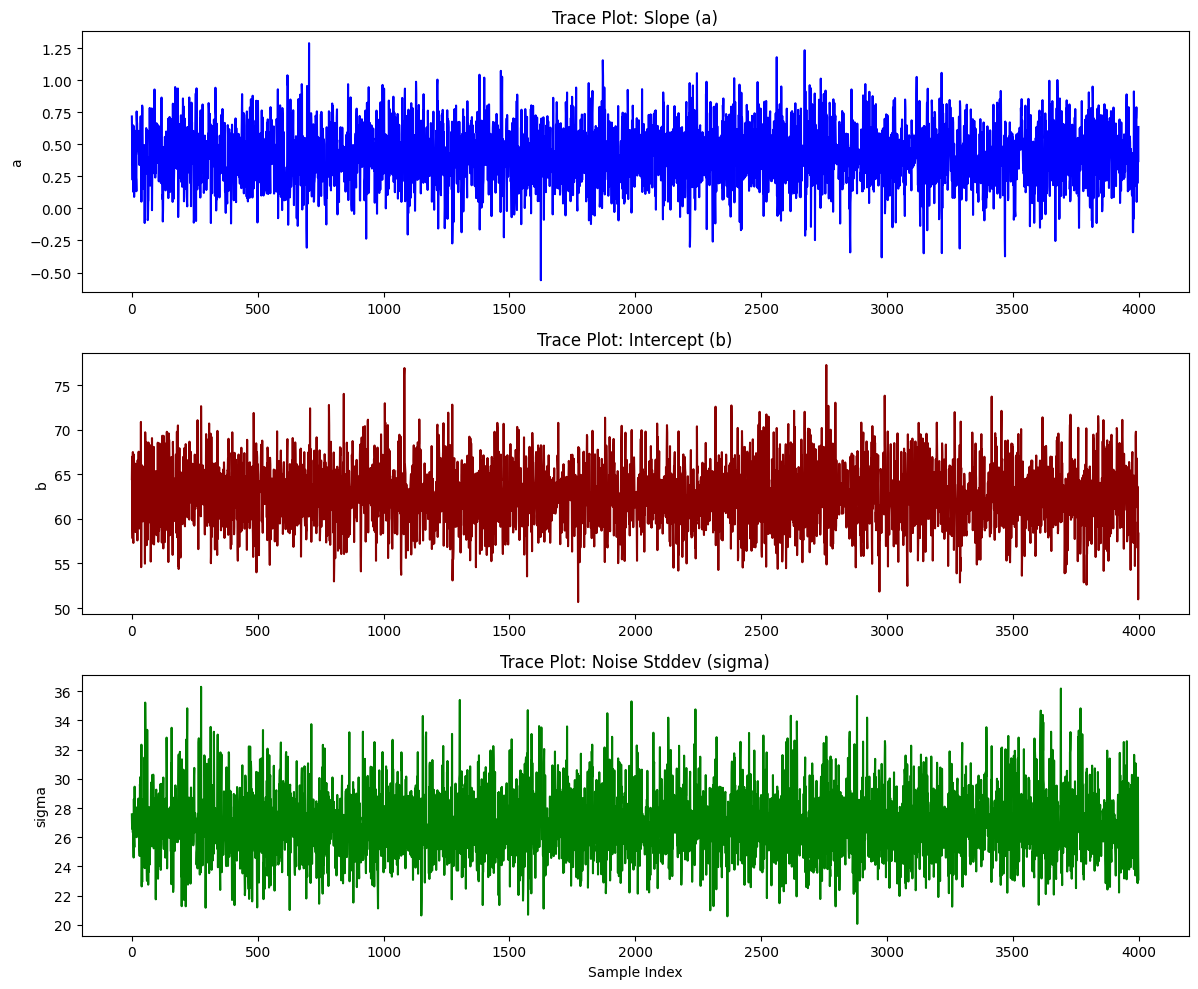

In [344]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

axes[0].plot(samples['a'], color='blue')
axes[0].set_title('Trace Plot: Slope (a)')
axes[0].set_ylabel('a')

axes[1].plot(samples['b'], color='darkred')
axes[1].set_title('Trace Plot: Intercept (b)')
axes[1].set_ylabel('b')

axes[2].plot(samples['sigma'], color='green')
axes[2].set_title('Trace Plot: Noise Stddev (sigma)')
axes[2].set_ylabel('sigma')
axes[2].set_xlabel('Sample Index')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Posterior of Noise Stddev (sigma)')

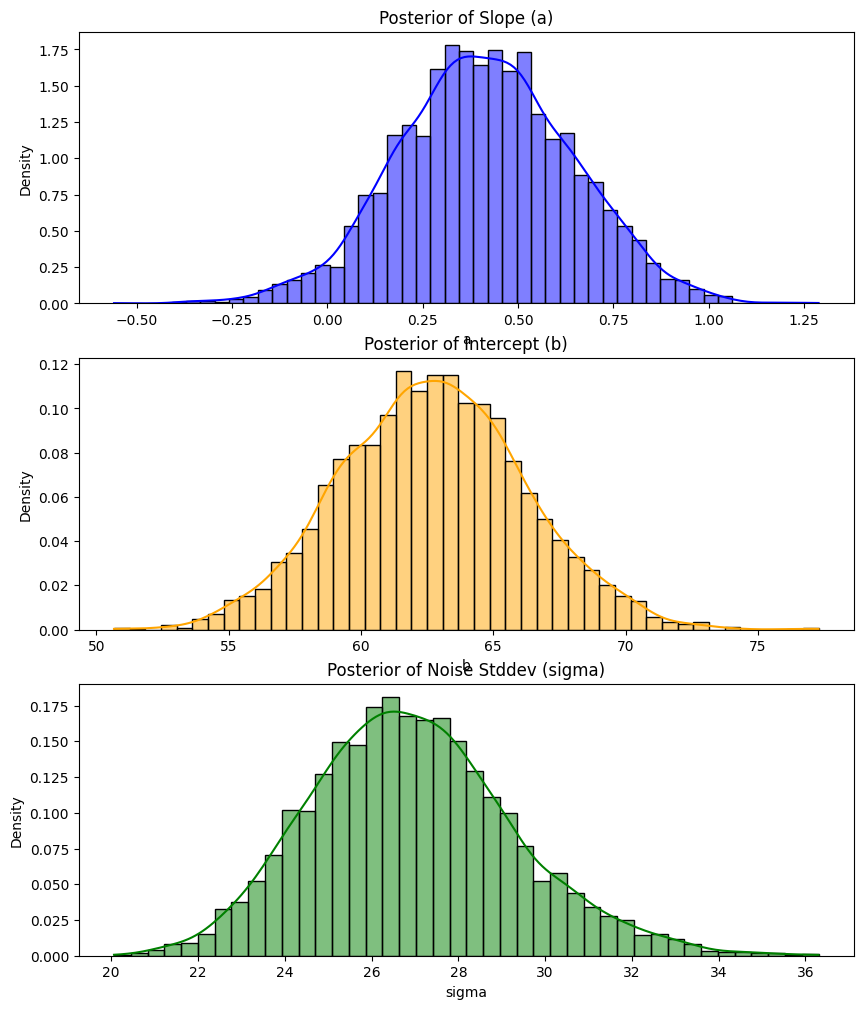

In [331]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False)
sns.histplot(samples['a'], kde=True, ax=axes[0], color='blue', stat='density')
sns.histplot(samples['b'], kde=True, ax=axes[1], color='orange', stat='density')
sns.histplot(samples['sigma'], kde=True, ax=axes[2], color='green', stat='density')
axes[0].set_title('Posterior of Slope (a)')
axes[1].set_title('Posterior of Intercept (b)')
axes[2].set_title('Posterior of Noise Stddev (sigma)')

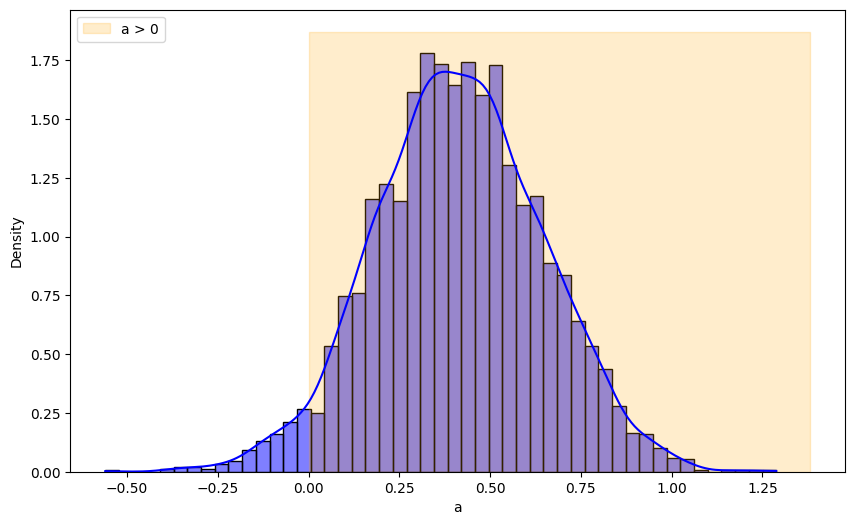

In [354]:
plt.figure(figsize=(10, 6))
sns.histplot(samples['a'], kde=True,  color='blue', stat='density')
plt.fill_betweenx(
    y=plt.gca().get_ylim(), x1=0, x2=plt.gca().get_xlim()[1], 
    color='orange', alpha=0.2, label='a > 0'
)
plt.legend()

In [337]:
prob_slope_ge_0 = (samples['a'] >= 0).mean()
print(f"Probability that slope >= 0: {prob_slope_ge_0:.3f}")
print(f"Probability that slope < 0: {1 - prob_slope_ge_0:.3f}")

Probability that slope >= 0: 0.964
Probability that slope < 0: 0.036


We looked at changes in snowfall in Norfolk County, Massachusetts, and concluded that we get more snowfall now than when I was young, contrary to my expectation.

## Marthon Speed Change

In [356]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
tables = pd.read_html(url)
len(tables)

6

In [357]:
table = tables[0]
table.tail(3)

,Time,Name,Nationality,Date,Event/Place,Source,Notes
49,2:01:39,Eliud Kipchoge,Kenya,"September 16, 2018",Berlin Marathon,IAAF[88],NaN
50,2:01:09,Eliud Kipchoge,Kenya,"September 25, 2022",Berlin Marathon,World Athletics[89],NaN
51,2:00:35,Kelvin Kiptum,Kenya,"October 8, 2023",Chicago Marathon,World Athletics[90],First man to break 2:01:00 in a record-eligibl...


In [358]:
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['date'].head()

0   1908-07-24
1   1909-01-01
2   1909-02-12
3   1909-05-08
4          NaT
Name: date, dtype: datetime64[ns]

In [422]:
table['time'] = pd.to_timedelta(table['Time'])
mph = True 
if mph:
    table['y'] = 26.2 / table['time'].dt.total_seconds() * 3600  # Convert to miles per hour
else: # Convert to kilometers per hour
    table['y'] = 42.195 / table['time'].dt.total_seconds() * 3600  # 42.195 km is the marathon distance
table['y'].head()

0    8.967143
1    9.099504
2    9.419942
3    9.465508
4    9.672854
Name: y, dtype: float64

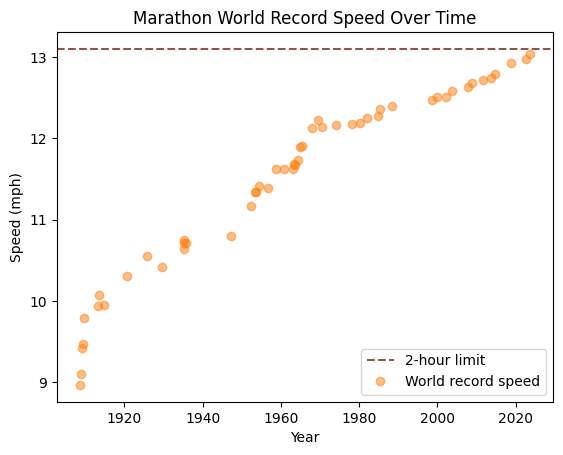

In [439]:
if mph:
    two_hour_limit = 26.2 / 7200 * 3600  # 2 hours in mph
else:
    two_hour_limit = 42.195 / 7200 * 3600

def plot_speeds(df):
    """Plot marathon world record speed as a function of time.
    
    df: DataFrame with date and mph
    """
    plt.axhline(two_hour_limit, color='C5', ls='--', label='2-hour limit')
    plt.plot(df['date'], df['y'], 'o', 
             label='World record speed', 
             color='C1', alpha=0.5)
    plt.xlabel('Year')
    plt.ylabel('Speed (km/h)' if not mph else 'Speed (mph)')
    plt.title('Marathon World Record Speed Over Time')
    plt.legend()
#
plot_speeds(table)

In [440]:
recent = table['date'] > pd.to_datetime('1970')
data = table.loc[recent].copy()
data.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y
32,2:09:28.8,Ron Hill,United Kingdom,"July 23, 1970","Edinburgh Commonwealth Games, Scotland",ARRS[19],NaN,1970-07-23,0 days 02:09:28.800000,12.140871
33,2:09:12,Ian Thompson,United Kingdom,"January 31, 1974","Christchurch Commonwealth Games, New Zealand",ARRS[19],NaN,1974-01-31,0 days 02:09:12,12.167183
34,2:09:05.6,Shigeru So,Japan,"February 5, 1978",Beppu-Ōita Marathon,ARRS[19],NaN,1978-02-05,0 days 02:09:05.600000,12.177236
35,2:09:01,Gerard Nijboer,Netherlands,"April 26, 1980",Amsterdam Marathon,ARRS[19],NaN,1980-04-26,0 days 02:09:01,12.184472
36,2:08:18,Robert De Castella,Australia,"December 6, 1981",Fukuoka Marathon,"IAAF,[52] ARRS[19]",NaN,1981-12-06,0 days 02:08:18,12.252533


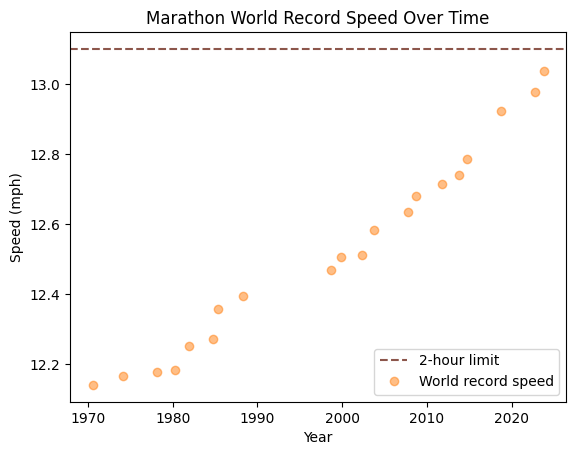

In [441]:
plot_speeds(data)

In [442]:
offset = pd.to_datetime('1995') # approximate midpoint of the data
timedelta = data['date'] - offset
data['x'] = timedelta.dt.total_seconds() / (365.25 * 24 * 3600)  # Convert to years
data['x'].describe()        

count    20.000000
mean      3.491718
std      16.863989
min     -24.443532
25%     -10.914442
50%       6.046543
75%      17.234086
max      28.766598
Name: x, dtype: float64

In [443]:
import statsmodels.formula.api as smf
formula = 'y ~ x'
model = smf.ols(formula, data=data).fit()
print(model.params)
print(model.bse)
print("resid.std: ", model.resid.std())

Intercept    12.467888
x             0.016466
dtype: float64
Intercept    0.011560
x            0.000688
dtype: float64
resid.std:  0.049218783293286106


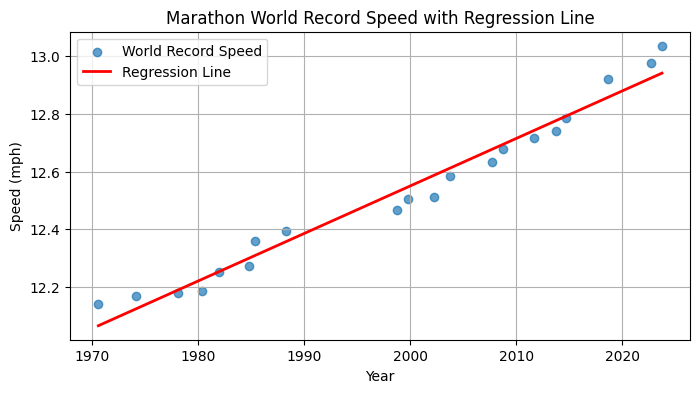

In [444]:
plt.figure(figsize=(8,4))
plt.scatter(data['date'], data['y'], alpha=0.7, label='World Record Speed')
plt.plot(data['date'], model.fittedvalues, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Year')
plt.ylabel('Speed (mph)')
plt.title('Marathon World Record Speed with Regression Line')
plt.legend()
plt.grid(True)
plt.show()


In [468]:
future_years = np.arange(2020, 2031)
future_years = pd.to_datetime(future_years, format='%Y')  # Convert to datetime
future_years - offset  # Center around the same offset

TimedeltaIndex([ '9131 days',  '9497 days',  '9862 days', '10227 days',
                '10592 days', '10958 days', '11323 days', '11688 days',
                '12053 days', '12419 days', '12784 days'],
               dtype='timedelta64[ns]', freq=None)

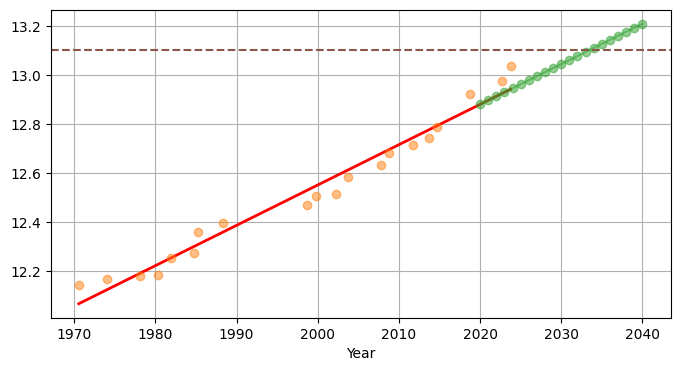

In [479]:
# prediction
# In what year will the marathon world record be under 2 hours?
future_years = np.arange(2020, 2041)
future_years = pd.to_datetime(future_years, format='%Y')  # Convert to datetime
future_x = (future_years - pd.to_datetime('1995')).total_seconds() / (365.25 * 24 * 3600)  # Convert to years
future_y = future_x * model.params['x'] + model.params['Intercept']
two_hour_limit = 26.2 / 7200 * 3600  #
plt.figure(figsize=(8, 4))
plt.plot(data['date'], model.fittedvalues, color='red', linewidth=2, label='Regression Line')
plt.plot(future_years, future_y, '-o', label='Predicted Speed', color='C2', alpha=0.5)
plt.plot(data['date'], data['y'], 'o', label='Observed Speed', color='C1', alpha=0.5)
plt.axhline(y=two_hour_limit, color='C5', ls='--', label='2-hour limit')
plt.xlabel('Year'); plt.grid(True);

In [481]:
future_df = pd.DataFrame({
    'date': future_years,
    'y': future_y
})
future_df[future_df.y > two_hour_limit]

,date,y
14,2034-01-01,13.110065
15,2035-01-01,13.126520
16,2036-01-01,13.142975
17,2037-01-01,13.159474
18,2038-01-01,13.175929
19,2039-01-01,13.192383
20,2040-01-01,13.208838


#### Bayesian Analysis

In [482]:
gamma_mean = model.resid.std()  # Standard deviation of residuals
gamma_std = gamma_mean / 5  # Adjusted standard deviation
gamma_shape = (gamma_mean / gamma_std) ** 2
gamma_rate = gamma_mean / gamma_std ** 2
print(f"Gamma prior parameters: shape = {gamma_shape:.3f}, rate = {gamma_rate:.3f} for mean= {gamma_mean:.3f}, std = {gamma_std:.3f}")

b_mean = model.params['Intercept']  # Intercept mean
b_std = b_mean / 5  # Adjusted standard deviation for intercept
print(f"Prior for intercept: mean = {b_mean:.3f}, std = {b_std:.3f}")

a_mean = model.params['x']  # Slope mean
a_std = a_mean / 5  # Adjusted standard deviation for slope
print(f"Prior for slope: mean = {a_mean:.3f}, std = {a_std:.3f}")

# Write Stan model to file
stan_code = """
data {
    real<lower=0> gamma_shape;  // shape parameter for Gamma prior
    real<lower=0> gamma_rate;   // rate parameter for Gamma prior
    real b_mean;  // prior mean for intercept
    real b_std;   // prior stddev for intercept
    real a_mean;  // prior mean for slope
    real a_std;   // prior stddev for slope

    int<lower=0> N;         // number of data points
    vector[N] x;            // predictor
    vector[N] y;            // response
}
parameters {
    real a;                 // slope
    real b;                 // intercept
    real<lower=0> sigma;    // noise stddev
}
model {
    a ~ normal(a_mean, a_std);  // prior for slope
    b ~ normal(b_mean, b_std);  // prior for intercept
    sigma ~ gamma(gamma_shape, gamma_rate);  // prior for noise stddev
    y ~ normal(a * x + b, sigma);
}
"""
print(stan_code)
# Let's use the same Stan code as before, but with different priors for sigma
with open('marathon_regression.stan', 'w') as f:
    f.write(stan_code)

Gamma prior parameters: shape = 25.000, rate = 507.936 for mean= 0.049, std = 0.010
Prior for intercept: mean = 12.468, std = 2.494
Prior for slope: mean = 0.016, std = 0.003

data {
    real<lower=0> gamma_shape;  // shape parameter for Gamma prior
    real<lower=0> gamma_rate;   // rate parameter for Gamma prior
    real b_mean;  // prior mean for intercept
    real b_std;   // prior stddev for intercept
    real a_mean;  // prior mean for slope
    real a_std;   // prior stddev for slope

    int<lower=0> N;         // number of data points
    vector[N] x;            // predictor
    vector[N] y;            // response
}
parameters {
    real a;                 // slope
    real b;                 // intercept
    real<lower=0> sigma;    // noise stddev
}
model {
    a ~ normal(a_mean, a_std);  // prior for slope
    b ~ normal(b_mean, b_std);  // prior for intercept
    sigma ~ gamma(gamma_shape, gamma_rate);  // prior for noise stddev
    y ~ normal(a * x + b, sigma);
}



In [483]:
from cmdstanpy import CmdStanModel

# Prepare data for Stan
stan_data = {
    'gamma_shape': float(gamma_shape),
    'gamma_rate': float(gamma_rate),
    'b_mean': b_mean,
    'b_std': b_std,
    'a_mean': a_mean,
    'a_std': a_std,
    'N': len(data),
    'x': data['x'].values.astype(float),
    'y': data['y'].values.astype(float)
}

# Compile Stan model (if not already compiled)
model = CmdStanModel(stan_file='marathon_regression.stan')

# Run MCMC sampling
fit = model.sample(data=stan_data, chains=4, iter_sampling=1000, iter_warmup=500, seed=42)

# Extract posterior samples as a pandas DataFrame
samples = fit.draws_pd()
print(samples.head())

08:53:19 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\marathon_regression.stan to exe file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\marathon_regression.exe
08:53:28 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\marathon_regression.exe
08:53:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▌         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                       


08:53:29 - cmdstanpy - INFO - CmdStan done processing.
08:53:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'marathon_regression.stan', line 22, column 4 to column 43)
	Exception: gamma_lpdf: Random variabl


   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -50.5400       0.975896     0.12639          4.0   
1      1.0     2.0     2.0 -49.8962       0.993941     0.12639          3.0   
2      1.0     3.0     3.0 -50.5827       0.907623     0.12639          4.0   
3      1.0     4.0     4.0 -50.0314       0.998948     0.12639          3.0   
4      1.0     5.0     5.0 -50.8427       0.959172     0.12639          3.0   

   n_leapfrog__  divergent__  energy__         a        b     sigma  
0          15.0          0.0   51.4253  0.016285  12.4537  0.048159  
1          15.0          0.0   52.0616  0.016040  12.4747  0.047942  
2          23.0          0.0   51.5759  0.017335  12.4702  0.048254  
3          15.0          0.0   50.6847  0.015827  12.4702  0.049320  
4          15.0          0.0   51.3298  0.017346  12.4735  0.052882  


In [484]:
print(samples[['a', 'b', 'sigma', 'lp__']].head())

          a        b     sigma     lp__
0  0.016285  12.4537  0.048159 -50.5400
1  0.016040  12.4747  0.047942 -49.8962
2  0.017335  12.4702  0.048254 -50.5827
3  0.015827  12.4702  0.049320 -50.0314
4  0.017346  12.4735  0.052882 -50.8427


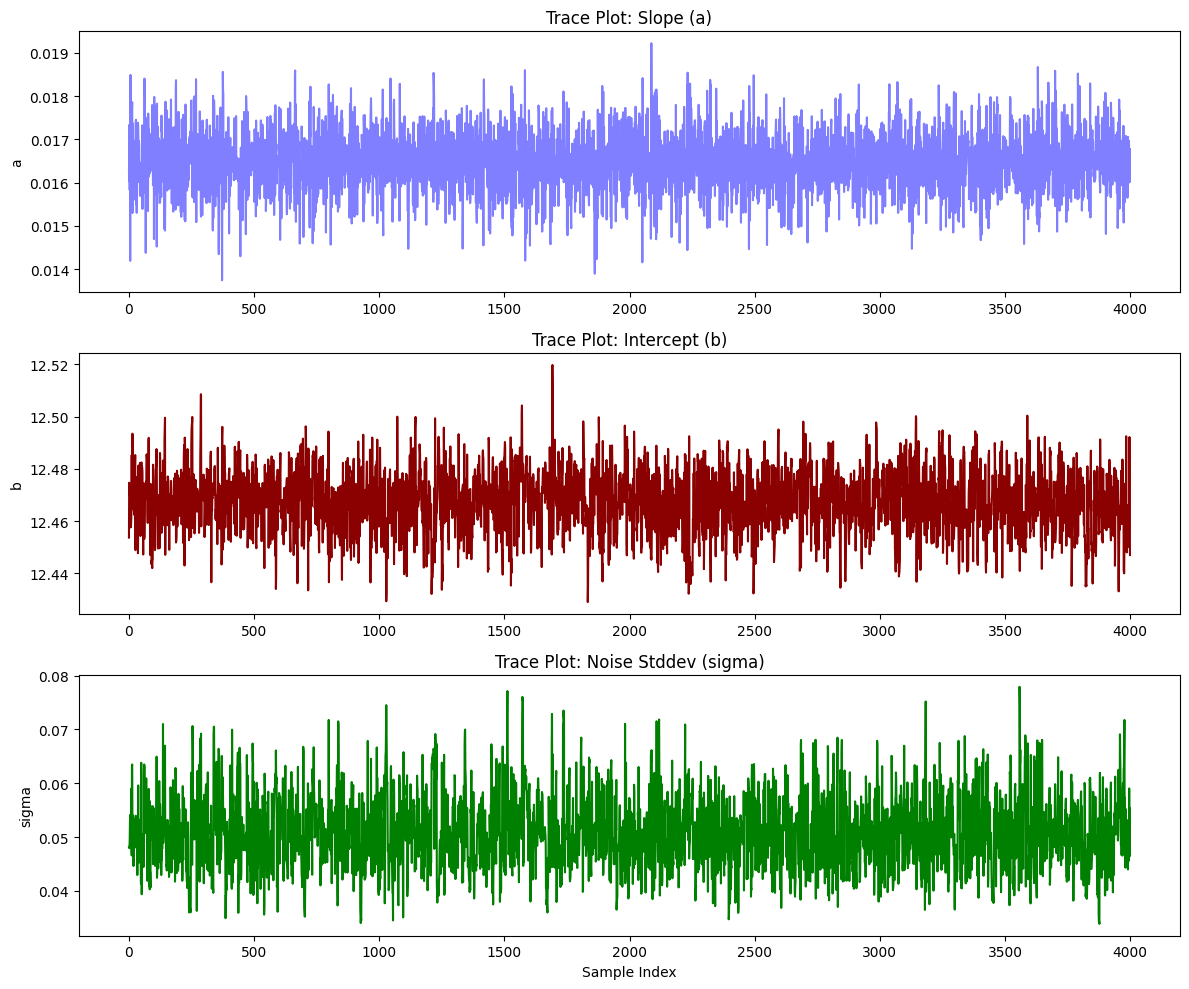

In [486]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

axes[0].plot(samples['a'], color='blue', alpha=0.5)
axes[0].set_title('Trace Plot: Slope (a)')
axes[0].set_ylabel('a')

axes[1].plot(samples['b'], color='darkred')
axes[1].set_title('Trace Plot: Intercept (b)')
axes[1].set_ylabel('b')

axes[2].plot(samples['sigma'], color='green')
axes[2].set_title('Trace Plot: Noise Stddev (sigma)')
axes[2].set_ylabel('sigma')
axes[2].set_xlabel('Sample Index')

plt.tight_layout()
plt.show()

In [487]:
 # Summary statistics for parameters
print(samples[['a', 'b', 'sigma']].describe()) 

ci_a = np.percentile(samples['a'], [5, 95])
ci_b = np.percentile(samples['b'], [5, 95])
ci_sigma = np.percentile(samples['sigma'], [5, 95])
print(f"90% credible interval for a: {ci_a[0]:.3f} to {ci_a[1]:.3f}")
print(f"90% credible interval for b: {ci_b[0]:.3f} to {ci_b[1]:.3f}")
print(f"90% credible interval for sigma: {ci_sigma[0]:.3f} to {ci_sigma[1]:.3f}")

                 a            b        sigma
count  4000.000000  4000.000000  4000.000000
mean      0.016485    12.467371     0.050866
std       0.000697     0.012111     0.006770
min       0.013740    12.429000     0.033870
25%       0.016035    12.459300     0.046052
50%       0.016489    12.467550     0.050435
75%       0.016939    12.475800     0.055096
max       0.019223    12.519800     0.077933
90% credible interval for a: 0.015 to 0.018
90% credible interval for b: 12.447 to 12.487
90% credible interval for sigma: 0.041 to 0.063


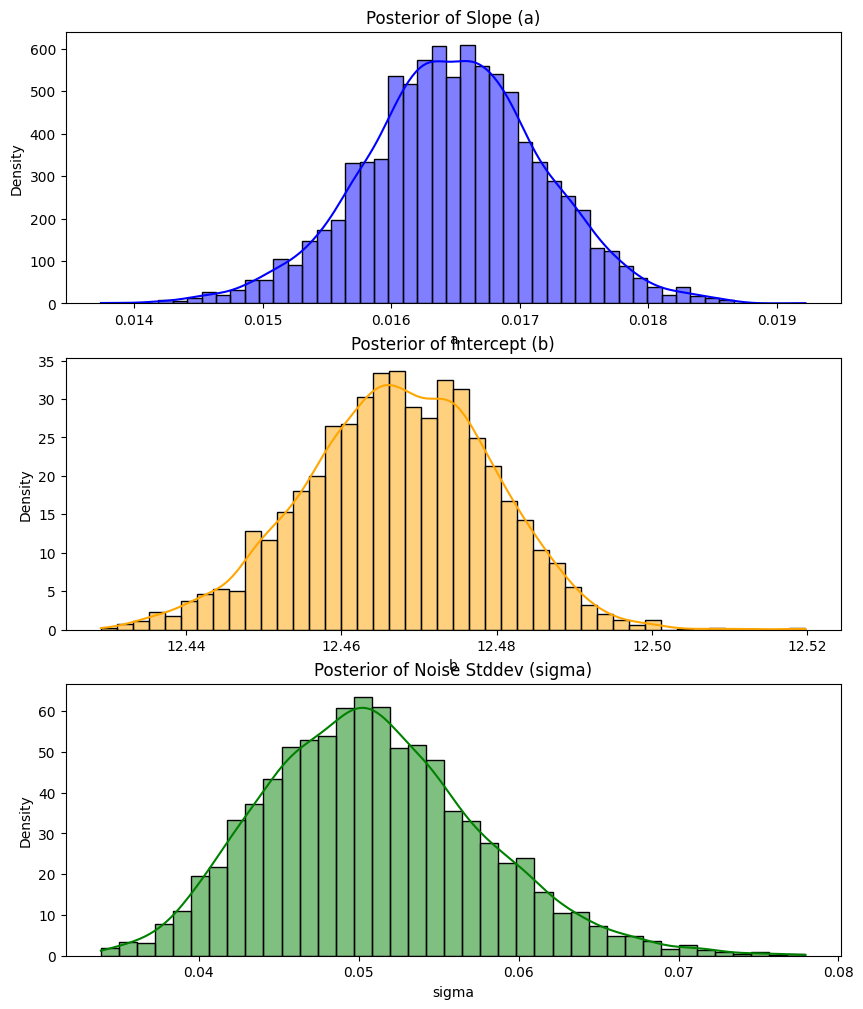

In [488]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False)
sns.histplot(samples['a'], kde=True, ax=axes[0], color='blue', stat='density')
sns.histplot(samples['b'], kde=True, ax=axes[1], color='orange', stat='density')
sns.histplot(samples['sigma'], kde=True, ax=axes[2], color='green', stat='density')
axes[0].set_title('Posterior of Slope (a)')
axes[1].set_title('Posterior of Intercept (b)')
axes[2].set_title('Posterior of Noise Stddev (sigma)');

In [489]:
print(f"Posterior mean of slope (a): {samples['a'].mean():.3f} per year; 95% CI: {ci_a[0]:.3f} to {ci_a[1]:.3f}")
print(f"Posterior mean of slope (a): {10*samples['a'].mean():.3f} per decade.")

Posterior mean of slope (a): 0.016 per year; 95% CI: 0.015 to 0.018
Posterior mean of slope (a): 0.165 per decade.


#### Question: When will there be a two-hour marathon?
- A prediction problem!

In [531]:
xs = np.arange(-25, 50, .5)
y_pred = np.empty((len(samples), len(xs)))
for i, (slope, intercept, sigma) in enumerate(zip(samples['a'], samples['b'], samples['sigma'])):
    y_pred[i] = slope * xs + intercept + np.random.normal(0, sigma, len(xs))

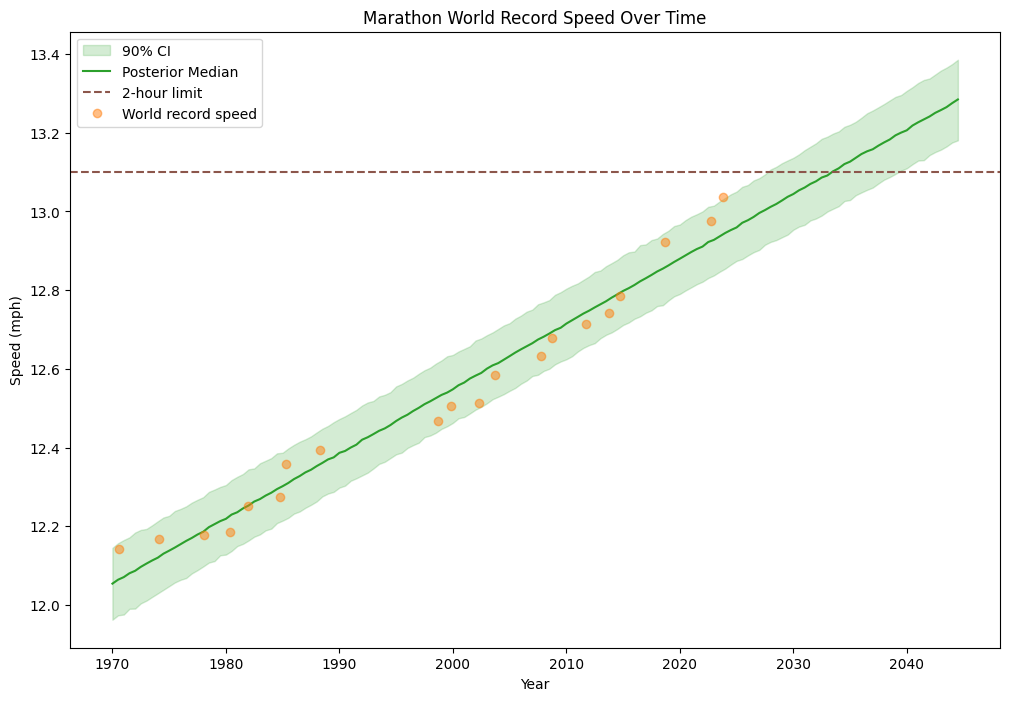

In [532]:
low, median, high = np.percentile(y_pred, [5, 50, 95], axis=0)
times = pd.to_timedelta(xs*365.25, unit='days') + offset  # Convert to timedelta
plt.figure(figsize=(12, 8))
plt.fill_between(times, low, high, color='C2', alpha=0.2, label='90% CI')
plt.plot(times, median, color='C2', label='Posterior Median')
plot_speeds(data)

In [533]:
times

DatetimeIndex(['1969-12-31 18:00:00', '1970-07-02 09:00:00',
               '1971-01-01 00:00:00', '1971-07-02 15:00:00',
               '1972-01-01 06:00:00', '1972-07-01 21:00:00',
               '1972-12-31 12:00:00', '1973-07-02 03:00:00',
               '1973-12-31 18:00:00', '1974-07-02 09:00:00',
               ...
               '2040-01-01 06:00:00', '2040-07-01 21:00:00',
               '2040-12-31 12:00:00', '2041-07-02 03:00:00',
               '2041-12-31 18:00:00', '2042-07-02 09:00:00',
               '2043-01-01 00:00:00', '2043-07-02 15:00:00',
               '2044-01-01 06:00:00', '2044-07-01 21:00:00'],
              dtype='datetime64[ns]', length=150, freq=None)

In [534]:
for i, (h, t) in enumerate(zip(high, times)):
    if h > two_hour_limit:
        print(f"Predicted year for sub-2-hour marathon: {t.year} {t.month} with speed {h:.2f} mph; {times[i-1]} with speed {h:.2f} mph")
        break
for m, t in zip(median, times):
    if m > two_hour_limit:
        print(f"Predicted year for sub-2-hour marathon: {t.year} with speed {m:.2f} mph")
        break
for l, t in zip(low, times):
    if l > two_hour_limit:
        print(f"Predicted year for sub-2-hour marathon: {t.year} with speed {l:.2f} mph")
        break

Predicted year for sub-2-hour marathon: 2028 1 with speed 13.11 mph; 2027-07-02 15:00:00 with speed 13.11 mph
Predicted year for sub-2-hour marathon: 2033 with speed 13.10 mph
Predicted year for sub-2-hour marathon: 2039 with speed 13.10 mph


In [535]:
# interpolation is done in speed-year space (not year-speed space)
from scipy.interpolate import interp1d
future = np.array([interp1d(high, xs)(13.1), interp1d(median, xs)(13.1), interp1d(low, xs)(13.1)])
dts = pd.to_timedelta(future*365.25, unit='days') + offset  # Convert to timedelta
pd.DataFrame(dict(datetime=dts), index=['early', 'median', 'late'])

,datetime
early,2027-09-26 17:28:57.443098356
median,2033-05-29 15:17:08.141827470
late,2039-04-14 12:05:15.709659158
